<a href="https://colab.research.google.com/github/kozen88/ProgettoIcon2023/blob/main/Cost_sensitive_learning_WORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COST SENSITIVE LEARNING PER AFFRONTARE l'IMBALANCE LEARNING
In questo notebook andremo ad utilizzare i dataset già preprocessati precedentemente e applicheremo modelli di apprendimento supervisionato con cost sensitive learning.

- COST SENSITIVE LEARNING: <p align="justify"> è una tecnica con la quale si marcano gli errori associandoli ad un peso differrente per ciascuna delle due classi, l'idea è quella di marcare con un peso più pesante e quindo andando a marcare un errore come più grave gli esempi della classe minoritaria di  modo che se il modello sbaglia a classificare questi esempi riceverà un feedback dal peso associato all'errore commesso che gli farà adattare la sua strategia di classificazione.

<p align="justify">NOTA: nella libreira che stiamo usando per il progetto ovvero scikit-learn offre a disposizione per la maggiorparte dei modelli una istanziazione con il parametro cost_sensitive che permette di apllicare il cost sensitve learning, tuttavia non tutti i modelli presenti nella libreria offrono questa implementazione e sfortunatamento il Gaussian Naive Bayes usato nei precedenti espereìimentri non dispone di tale parametro per tali ragioni in questo notebook metteremo a confronto nuovi classificatori.

In [2]:
from ast import increment_lineno
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import precision_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
sns.set_style('darkgrid')

In [44]:
df_impiegati = pd.read_excel('Impiegati_one_hot_standardize.xlsx')
# Rimescola il DataFrame in modo casuale
df_impiegati = df_impiegati.sample(frac=1, random_state=42)

## BREVE VISUALIZZAZIONE DELLO SBILANCIAMENTO
Qui andiamo a ricapitolare come appare il nostro dataset dopo le elaborazioni fatte in precedenza e andaimo a inquadrare nuovamente la sitauzione di sbilancio del dataset prima di anandare ad applicare l'addestramento

In [45]:
df_impiegati

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department_RandD,department_accounting,department_human_resources,department_management,department_marketing,department_product_mng,department_sales,department_technical,salary_high,salary_low,salary_medium,left
6723,0.149490,1.424944,0.971113,0.499578,-1.026126,2.432112,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,4.059723,-0.252953,-0.617455,-0.836653,-0.299809,-0.975824,1.151898,0
6473,1.074587,0.490165,-0.651538,-0.701829,-1.026126,-0.411165,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,-0.617455,1.195238,-0.299809,1.024775,-0.868132,0
4679,0.310376,1.541791,-0.651538,0.259297,-1.026126,-0.411165,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.836653,-0.299809,1.024775,-0.868132,0
862,-0.815830,-1.437818,-1.462863,-0.942110,-0.341235,-0.411165,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.836653,-0.299809,1.024775,-0.868132,1
7286,1.034366,0.256470,0.971113,1.060235,-1.026126,2.432112,-0.147412,-0.235321,-0.232148,4.392761,-0.209391,-0.246322,-0.252953,-0.617455,-0.836653,-0.299809,1.024775,-0.868132,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,-0.373392,1.424944,0.159788,0.900048,-0.341235,-0.411165,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,-0.617455,1.195238,-0.299809,1.024775,-0.868132,0
13418,-0.494057,-0.386191,0.159788,0.639743,2.398327,-0.411165,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.836653,-0.299809,-0.975824,1.151898,0
5390,0.189711,0.081199,0.971113,0.960118,-1.026126,-0.411165,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,-0.617455,1.195238,-0.299809,-0.975824,1.151898,0
860,0.712593,1.658639,0.159788,0.339391,1.028546,-0.411165,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.836653,-0.299809,1.024775,-0.868132,1


In [5]:
def plot_class_distribution(class_counts, title):
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="pastel", alpha=0.8)
    plt.xlabel('Classe\nRestano=0  vs  Lasciano=1')
    plt.ylabel('Numero di impiegati per classe')
    plt.title(title)

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

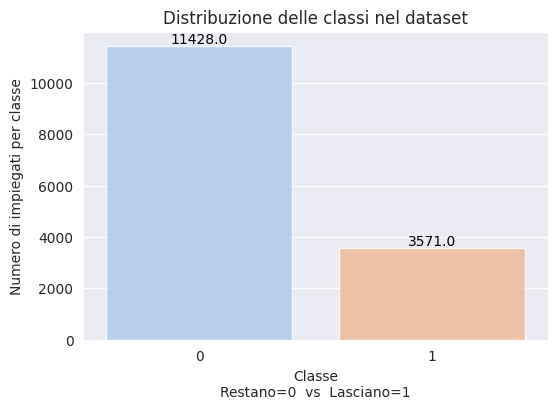

In [23]:

class_counts_check = df_impiegati['left'].value_counts()

# Crea un barplot per mostrare lo sbilanciamento tra le classi dopo lo SMOOTEEEN
plot_class_distribution(class_counts_check, 'Distribuzione delle classi nel dataset')

In [24]:
def plot_pie_chart(class_counts, title, legend_labels, startangle=40, fontsize=12, fontweight='bold'):
    plt.figure(figsize=(6, 6))
    colors = sns.color_palette('pastel')
    sns.set_palette(colors)

    def func(pct, allvalues):
        absolute = int(pct / 100. * np.sum(allvalues))
        return f"{pct:.2f}%\n({absolute:,d})"

    explode = (0.02,) + (0,) * (len(class_counts) - 1)  # Add space only to the first slice

    plt.pie(class_counts, labels=class_counts.index, autopct=lambda pct: func(pct, class_counts), startangle=startangle,
            textprops={'fontsize': fontsize, 'fontweight': fontweight}, explode=explode, shadow=True)

    plt.title(title)
    plt.axis('equal')

    plt.legend(legend_labels, loc='lower right')  # Custom legend

    plt.show()

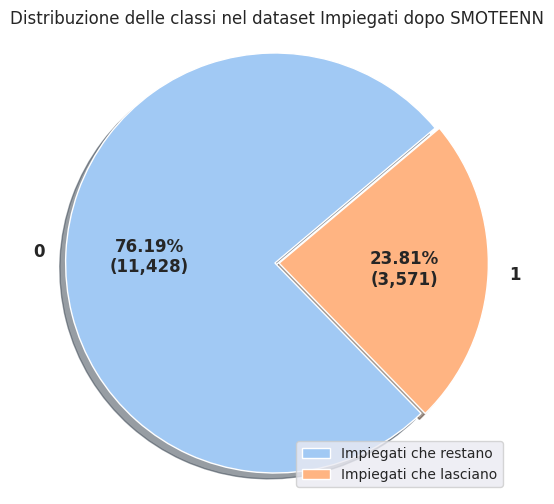

In [25]:
legend_labels = ['Impiegati che restano', 'Impiegati che lasciano']
plot_pie_chart(class_counts_check, 'Distribuzione delle classi nel dataset Impiegati dopo SMOTEENN', legend_labels, startangle=40, fontsize=12, fontweight='bold')

## COST INSENSITIVE LEARNING

Di seguito si riportano delle funzioni di suppurto per la valutazione dei risultati dopo l'addestramento dei modelli

In [34]:
def stampa_metriche(pred_train, pred_test, y_train, y_test, model):
    # Calcola e stampa l'accuracy per il train set e il test set
    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_test = accuracy_score(y_test, pred_test)
    print("----------CONFRONTO PERFORMANCE TRAIN VS TEST-----------")
    print(f"Modello valutato: {model}")
    print(f'Accuracy (Train): {accuracy_train}')
    print(f'Accuracy (Test): {accuracy_test}')

    # Calcola e stampa precision, recall, e F1-score per il train set e il test set
    precision_train = precision_score(y_train, pred_train, average='macro')
    recall_train = recall_score(y_train, pred_train, average='macro')
    f1_train = f1_score(y_train, pred_train, average='macro')

    precision_test = precision_score(y_test, pred_test, average='macro')
    recall_test = recall_score(y_test, pred_test, average='macro')
    f1_test = f1_score(y_test, pred_test, average='macro')

    print(f'Precision (Train): {precision_train}')
    print(f'Precision (Test): {precision_test}')
    print(f'Recall (Train): {recall_train}')
    print(f'Recall (Test): {recall_test}')
    print(f'F1-Score (Train): {f1_train}')
    print(f'F1-Score (Test): {f1_test}')

    # Stampa classification report per il train set e il test set
    print('Classification Report (Train):\n', classification_report(y_train, pred_train))
    print('Classification Report (Test):\n', classification_report(y_test, pred_test))

In [56]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', fontsize=22, title_color='#660000'):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Calcola le percentuali
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap='OrRd')  # Utilizza fmt=".2%" per visualizzare le percentuali con due decimali
    plt.title(title, fontsize=fontsize, color=title_color)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

- Preparazione feature di input e feature di output e divisione tramite hold-out

In [46]:
# Separiamo input da output prima di iniziare l'addesttramento
X = df_impiegati.drop("left", axis=1)
y = df_impiegati["left"]

In [47]:
# Andiamo a suddividere il dataset in train set e test set con un hold-out 70:30
X_train, X_test, y_train, y_test  = train_test_split (X, y, test_size=0.3, random_state=30)

# verifica del hold out
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (10499, 18)
X_test shape:  (4500, 18)
y_train.shape:  (10499,)
y_test shape:  (4500,)


In [62]:
# istanziazzione dei modelli da mettere a confronto
sgdc = SGDClassifier(loss='log', random_state=30)
perceptron = Perceptron(random_state=30)

# adestramento base su hold-out per stochastic gradient descent
sgdc.fit(X_train, y_train)
pred_train_sgdc = sgdc.predict(X_train)
pred_test_sgdc = sgdc.predict(X_test)


# adestramento base su hold-out per percettrone
perceptron.fit(X_train, y_train)
pred_train_perceptron = perceptron.predict(X_train)
pred_test_perceptron = perceptron.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [63]:
# Utilizzo della funzione per mostrare le predizioni a confronto tra train e test
stampa_metriche(pred_train_sgdc, pred_test_sgdc, y_train, y_test, "STOCHASTIC GRADIENT DESCENT")

----------CONFRONTO PERFORMANCE TRAIN VS TEST-----------
Modello valutato: STOCHASTIC GRADIENT DESCENT
Accuracy (Train): 0.8025526240594343
Accuracy (Test): 0.81
Precision (Train): 0.7324278822868435
Precision (Test): 0.7374208337505235
Recall (Train): 0.678902976111833
Recall (Test): 0.6860250230725734
F1-Score (Train): 0.6967230470090817
F1-Score (Test): 0.7039872513329422
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      7977
           1       0.63      0.44      0.52      2522

    accuracy                           0.80     10499
   macro avg       0.73      0.68      0.70     10499
weighted avg       0.79      0.80      0.79     10499

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.85      0.92      0.88      3451
           1       0.63      0.45      0.53      1049

    accuracy                           0.81      4500
   macro avg  

Non ci sono variazioni tra il train e il test, sospettiamo che il dataset sul quale stiamo lavorando sia un dataset sperimentale a scopo educativo, dato che molti dei modelli non riportano signioficative differenze tra le performance di train e quelle di test.

In [70]:
print("_____STOCHASTIC GRADIENT DESCENT COST INSENSITIVE_______")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_test_sgdc))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_test_sgdc))

_____STOCHASTIC GRADIENT DESCENT COST INSENSITIVE_______
------------------------Accuracy------------------------

0.81

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      3451
           1       0.63      0.45      0.53      1049

    accuracy                           0.81      4500
   macro avg       0.74      0.69      0.70      4500
weighted avg       0.80      0.81      0.80      4500



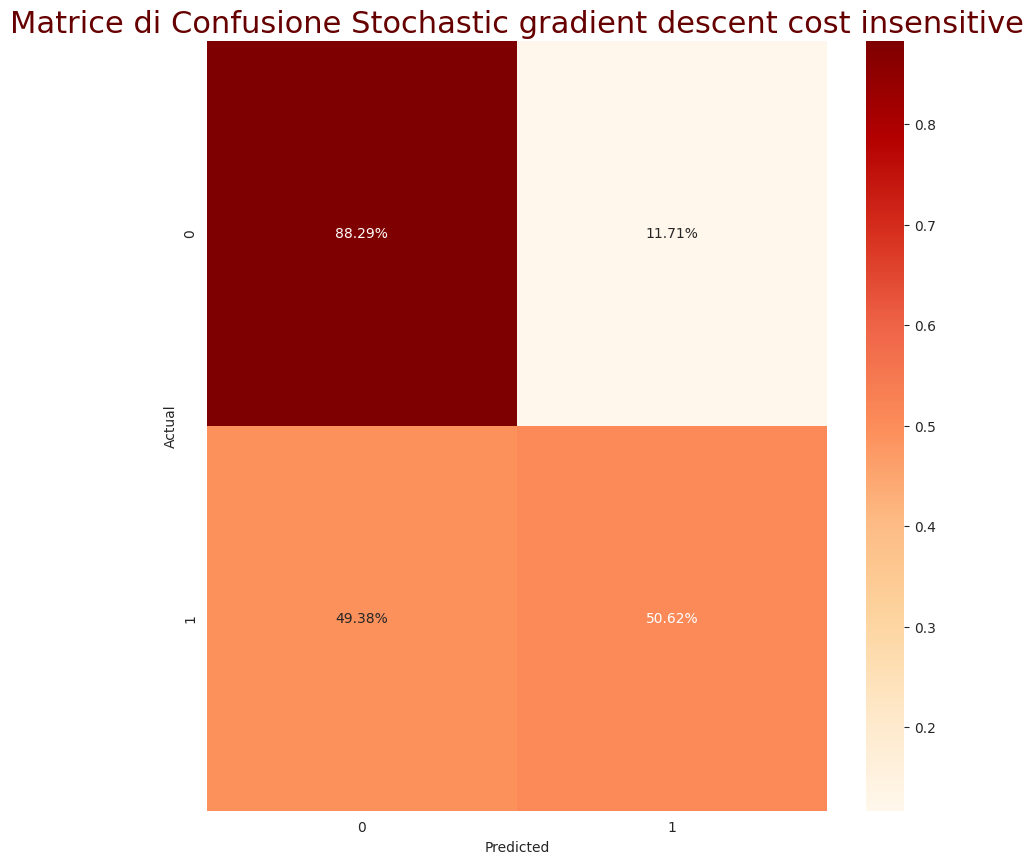

In [58]:
plot_confusion_matrix(y_test, pred_test_sgdc, "Matrice di Confusione Stochastic gradient descent cost insensitive")

In [71]:
# Utilizzo della funzione per mostrare le predizioni a confronto tra train e test
stampa_metriche(pred_train_perceptron, pred_test_perceptron, y_train, y_test, "PERCETTRONE")

----------CONFRONTO PERFORMANCE TRAIN VS TEST-----------
Modello valutato: PERCETTRONE
Accuracy (Train): 0.7687398799885703
Accuracy (Test): 0.7804444444444445
Precision (Train): 0.6756544431582321
Precision (Test): 0.6881885670747143
Recall (Train): 0.6512284972348634
Recall (Test): 0.6694093172590031
F1-Score (Train): 0.660563470903042
F1-Score (Test): 0.6773131551718732
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      7977
           1       0.52      0.43      0.47      2522

    accuracy                           0.77     10499
   macro avg       0.68      0.65      0.66     10499
weighted avg       0.76      0.77      0.76     10499

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      3451
           1       0.53      0.46      0.49      1049

    accuracy                           0.78      4500
   macro avg    

Anche per il percettrone sinota la stranezza come per lo stochastic gradient descent a riguardo delle differenze sulle performance tra train e test.

In [72]:
print("_____________PERCETTRONE COST INSENSITIVE_______________")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_test_perceptron))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_test_perceptron))

_____________PERCETTRONE COST INSENSITIVE_______________
------------------------Accuracy------------------------

0.7804444444444445

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3451
           1       0.53      0.46      0.49      1049

    accuracy                           0.78      4500
   macro avg       0.69      0.67      0.68      4500
weighted avg       0.77      0.78      0.77      4500



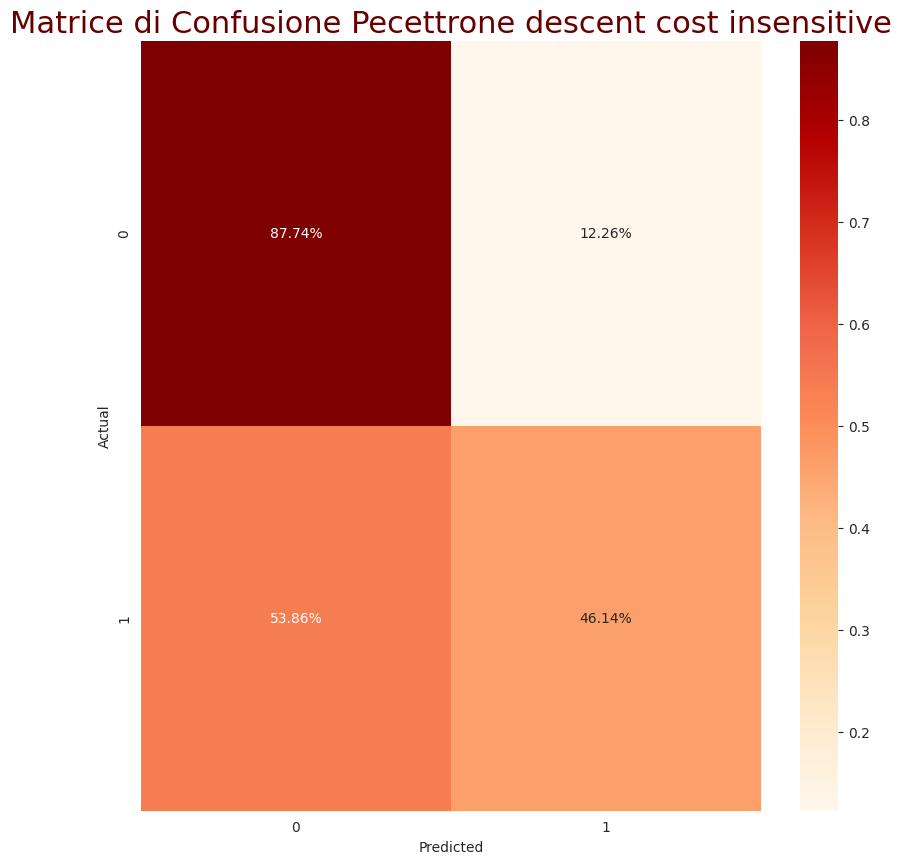

In [73]:
plot_confusion_matrix(y_test, pred_test_perceptron, "Matrice di Confusione Pecettrone descent cost insensitive")

- CURVA ROC: Andiamo a mettere a confronto i due classificatori addestrati sul dataset per vedere chi è andato meglio e quale scegliere per il task.

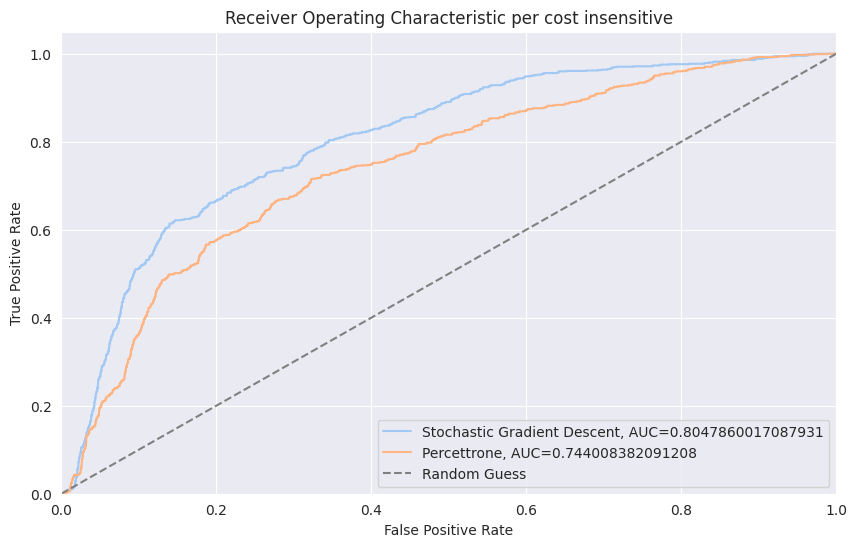

In [84]:
# Calcola i punteggi delle probabilità positive
pred_sgdc_positive = sgdc.predict_proba(X_test)[:, 1]
pred_perceptron_positive = perceptron.decision_function(X_test)

# Calcola le curve ROC e gli AUC
fpr_sgdc, tpr_sgdc, _ = roc_curve(y_test, pred_sgdc_positive)
auc_sgdc = roc_auc_score(y_test, pred_sgdc_positive)

fpr_perceptron, tpr_perceptron, _ = roc_curve(y_test, pred_perceptron_positive)
auc_perceptron = roc_auc_score(y_test, pred_perceptron_positive)

# Crea il grafico ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_sgdc, tpr_sgdc, label="Stochastic Gradient Descent, AUC=" + str(auc_sgdc))
plt.plot(fpr_perceptron, tpr_perceptron, label="Percettrone, AUC=" + str(auc_perceptron))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic per cost insensitive')
plt.legend(loc='lower right')
plt.show()

- COCNLUSIONI:

## COST SENSITIVE LEARNING

In [75]:
# istanziazzione dei modelli da mettere a confronto
sgdc_cs = SGDClassifier(loss='log', class_weight='balanced', random_state=30)
perceptron_cs = Perceptron(class_weight='balanced', random_state=30)

# adestramento base su hold-out per stochastic gradient descent
sgdc_cs.fit(X_train, y_train)
pred_train_sgdc_cs = sgdc_cs.predict(X_train)
pred_test_sgdc_cs = sgdc_cs.predict(X_test)


# adestramento base su hold-out per percettrone
perceptron_cs.fit(X_train, y_train)
pred_train_perceptron_cs = perceptron_cs.predict(X_train)
pred_test_perceptron_cs = perceptron_cs.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [76]:
# Utilizzo della funzione per mostrare le predizioni a confronto tra train e test
stampa_metriche(pred_train_sgdc_cs, pred_test_sgdc_cs, y_train, y_test, "STOCHASTIC GRADIENT DESCENT")

----------CONFRONTO PERFORMANCE TRAIN VS TEST-----------
Modello valutato: STOCHASTIC GRADIENT DESCENT
Accuracy (Train): 0.748928469378036
Accuracy (Test): 0.7455555555555555
Precision (Train): 0.6971331694508418
Precision (Test): 0.6922670082684298
Recall (Train): 0.7538366151217661
Recall (Test): 0.7531568888033173
F1-Score (Train): 0.7059717036201456
F1-Score (Test): 0.7005226685885912
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      7977
           1       0.49      0.76      0.59      2522

    accuracy                           0.75     10499
   macro avg       0.70      0.75      0.71     10499
weighted avg       0.81      0.75      0.76     10499

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      3451
           1       0.47      0.77      0.58      1049

    accuracy                           0.75      4500


In [79]:
print("_______STOCHASTIC GRADIENT DESCENT COST SENSITIVE_______")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_test_sgdc_cs))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_test_sgdc_cs))

_______STOCHASTIC GRADIENT DESCENT COST SENSITIVE_______
------------------------Accuracy------------------------

0.7455555555555555

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      3451
           1       0.47      0.77      0.58      1049

    accuracy                           0.75      4500
   macro avg       0.69      0.75      0.70      4500
weighted avg       0.81      0.75      0.76      4500



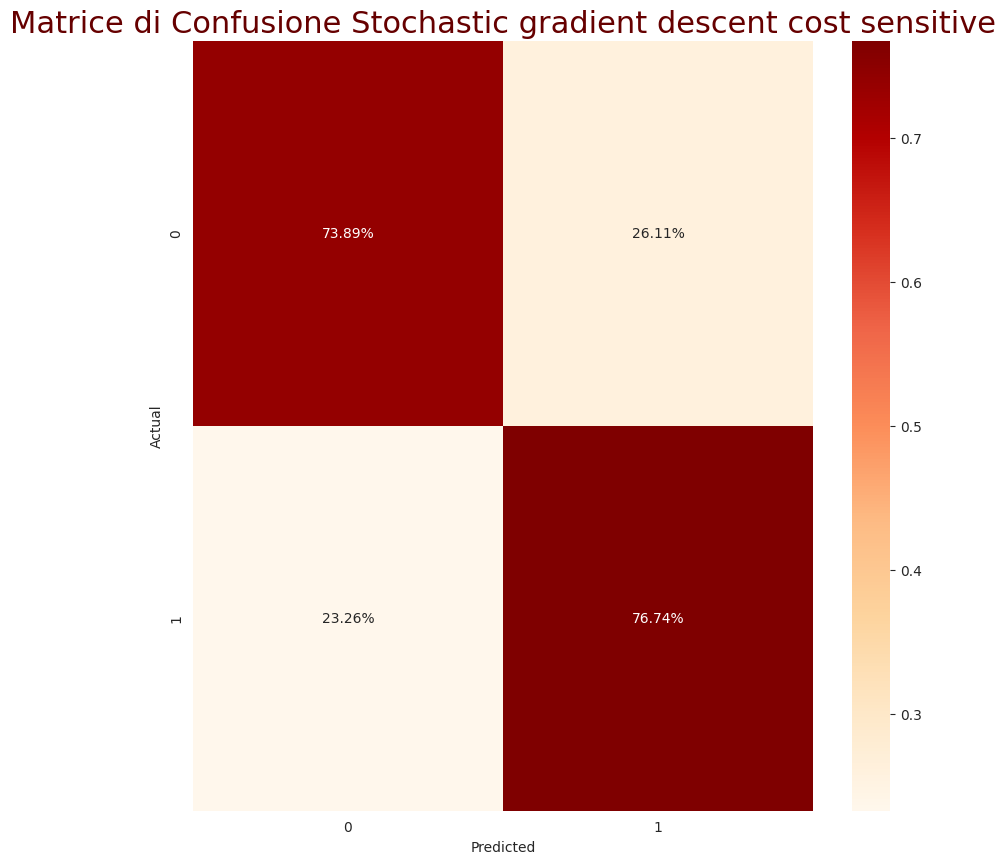

In [80]:
plot_confusion_matrix(y_test, pred_test_sgdc_cs, "Matrice di Confusione Stochastic gradient descent cost sensitive")

In [81]:
# Utilizzo della funzione per mostrare le predizioni a confronto tra train e test
stampa_metriche(pred_train_perceptron_cs, pred_test_perceptron_cs, y_train, y_test, "PERCETTRONE")

----------CONFRONTO PERFORMANCE TRAIN VS TEST-----------
Modello valutato: PERCETTRONE
Accuracy (Train): 0.7434041337270216
Accuracy (Test): 0.7562222222222222
Precision (Train): 0.6572476494484065
Precision (Test): 0.6708440530377994
Recall (Train): 0.6699406759938391
Recall (Test): 0.6907737882306533
F1-Score (Train): 0.6625576952811082
F1-Score (Test): 0.6786442242963715
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.84      0.81      0.83      7977
           1       0.47      0.53      0.50      2522

    accuracy                           0.74     10499
   macro avg       0.66      0.67      0.66     10499
weighted avg       0.75      0.74      0.75     10499

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.86      0.81      0.84      3451
           1       0.48      0.57      0.52      1049

    accuracy                           0.76      4500
   macro avg   

In [82]:
print("_______________PERCETTRONE COST SENSITIVE_______________")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_test_perceptron_cs))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_test_perceptron_cs))

_______________PERCETTRONE COST SENSITIVE_______________
------------------------Accuracy------------------------

0.7562222222222222

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      3451
           1       0.48      0.57      0.52      1049

    accuracy                           0.76      4500
   macro avg       0.67      0.69      0.68      4500
weighted avg       0.77      0.76      0.76      4500



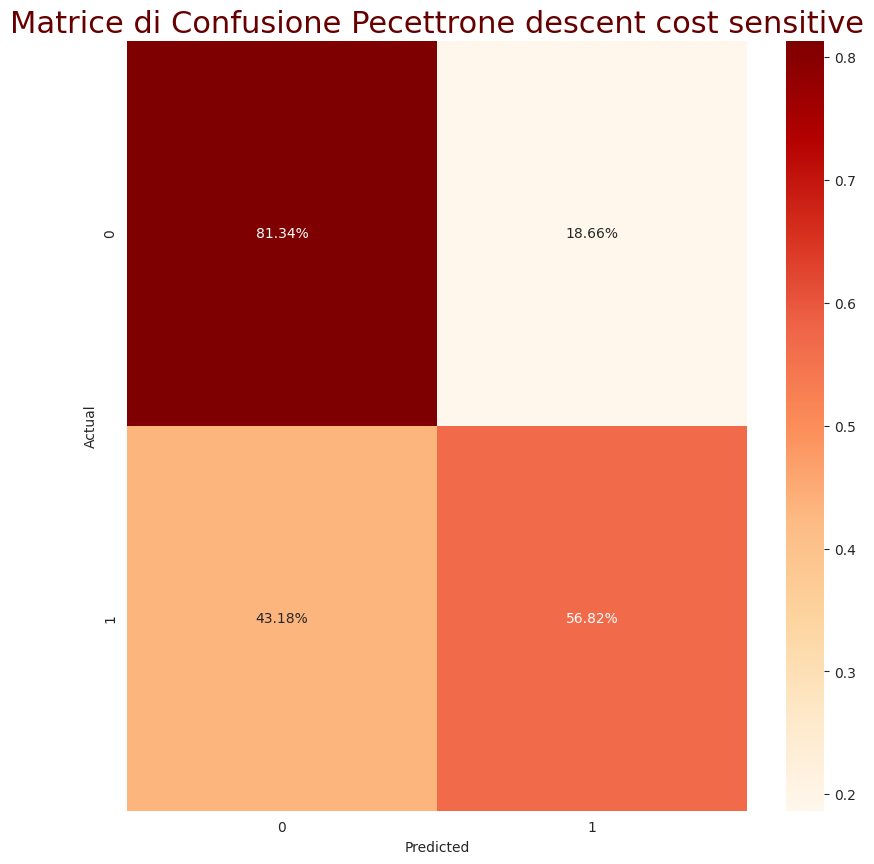

In [83]:
plot_confusion_matrix(y_test, pred_test_perceptron_cs, "Matrice di Confusione Pecettrone descent cost sensitive")

- CURVA ROC: Mettiamo a confronto i 2 classificatori addestrati dopo aver applicato un addestramentto sensibile alla classe minoritaria e vedere i risultati che abbiamo ottenuto.

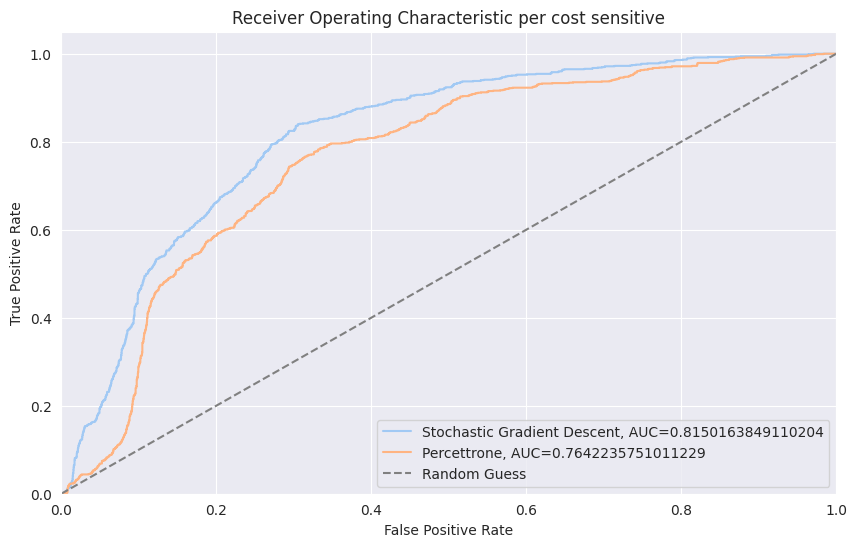

In [85]:
# Calcola i punteggi delle probabilità positive
pred_sgdc_cs_positive = sgdc_cs.predict_proba(X_test)[:, 1]
pred_perceptron_cs_positive = perceptron_cs.decision_function(X_test)

# Calcola le curve ROC e gli AUC
fpr_sgdc_cs, tpr_sgdc_cs, _ = roc_curve(y_test, pred_sgdc_cs_positive)
auc_sgdc_cs = roc_auc_score(y_test, pred_sgdc_cs_positive)

fpr_perceptron_cs, tpr_perceptron_cs, _ = roc_curve(y_test, pred_perceptron_cs_positive)
auc_perceptron_cs = roc_auc_score(y_test, pred_perceptron_cs_positive)

# Crea il grafico ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_sgdc_cs, tpr_sgdc_cs, label="Stochastic Gradient Descent, AUC=" + str(auc_sgdc_cs))
plt.plot(fpr_perceptron_cs, tpr_perceptron_cs, label="Percettrone, AUC=" + str(auc_perceptron_cs))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic per cost sensitive')
plt.legend(loc='lower right')
plt.show()

- CONCLUSIONI:

- CONFRONTO COST SENSITIVE VS COST INSENSITIVE SU ROC:
adremo aplottare i risultati ottenuti dalla nostra sperimentazione delle metodologie per affrontare l'imballance learniong e in particolare andreo a creare un grafico che metta in evidenza lo score ROC e AUROC per i classificatori addestrati.

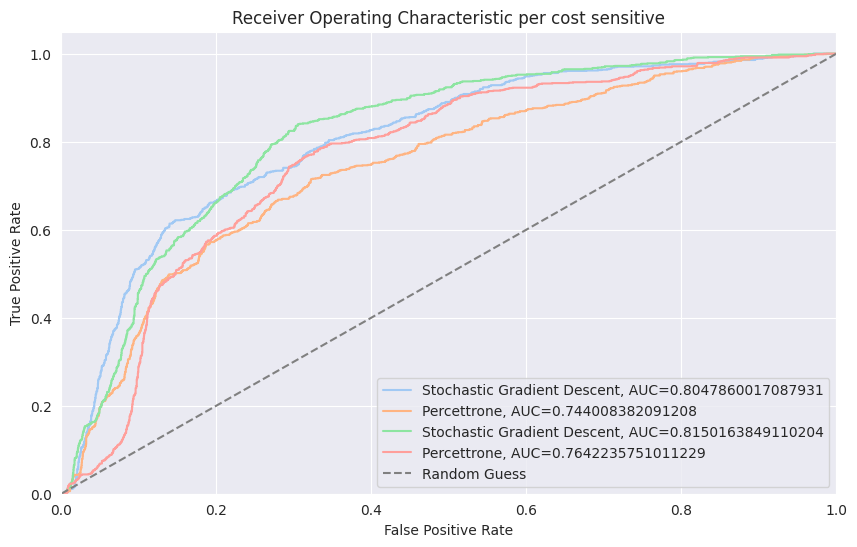

In [86]:
# Crea il grafico ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_sgdc, tpr_sgdc, label="Stochastic Gradient Descent, AUC=" + str(auc_sgdc))
plt.plot(fpr_perceptron, tpr_perceptron, label="Percettrone, AUC=" + str(auc_perceptron))
plt.plot(fpr_sgdc_cs, tpr_sgdc_cs, label="Stochastic Gradient Descent, AUC=" + str(auc_sgdc_cs))
plt.plot(fpr_perceptron_cs, tpr_perceptron_cs, label="Percettrone, AUC=" + str(auc_perceptron_cs))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic per cost sensitive')
plt.legend(loc='lower right')
plt.show()

#### CONCLUSIONI STUDIO SUL COST SENSITIVE LEARNING